# Project 1 - due 3rd Nov

## Step 1: Run pseudoexperiments for 10000 events

- the pdf is: $$p(t;\tau, \Delta m, V) \propto (1 + V\sin{\Delta m t}) e^{-\frac{t}{\tau}}$$
- nominal values are: $$\tau = 1.5\times 10^{-6}\ \text{s} $$ $$\Delta m = 20\times 10^{6}\ \text{s}^{-1} $$ $$V = 0.1$$

In [2]:

# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from scipy.interpolate import interp1d
from iminuit import Minuit # for the minimising
from iminuit.cost import UnbinnedNLL # for obtaining the NLL when we have unbinned data


# matplotlib settings
plt.style.use('bmh')


# set seed for reproducibility
np.random.seed(42)  


In [3]:

# nominal parameter values
tau_nom = 2e-6
dm_nom = 20e6
V_nom = 0.25 # takes 0 if universe non-symmetric

bounds = [5e-7, 1e-5] # range of t values in which to generate data


# define pdf (not normalised)
def pdf(t, tau, dm, V):
    return (1 + V*np.sin(dm*t))*np.exp(-t/tau)


# define normalised pdf
def norm_pdf(t, tau, dm, V):

    t_samples = np.linspace(bounds[0], bounds[1], 1000)
    y_pdf = pdf(t_samples, tau, dm, V)
    N = integrate.trapezoid(y_pdf, t_samples) # use trapezoidal numerical integration for speed

    return pdf(t, tau, dm, V) / N


# define cdf (cumulative distribution function)
def cdf(i, tau, dm, V):

    t_samples = np.linspace(bounds[0], i, 1000)
    y_pdf = norm_pdf(t_samples, tau, dm, V)

    return integrate.trapezoid(y_pdf, t_samples)# integrate from lower bound to given i


# define event generation function
def generate():

    x = np.linspace(bounds[0], bounds[1], 1000) # interpolation points
    cdf_values = cdf(x, tau_nom, dm_nom, V_nom) # cdf values
    r = np.random.rand(10000) # random r's in range [0,1]
    events = np.interp(r, cdf_values, x, left=0, right=1) # inverse transform sampling (EXPLAIN)
    
    return events


# call the function to generate events
data = generate()


- Using iminuit, fit to these generated samples with the same $\tau$, $\Delta m$ and $V$ parameter values and obtain the error on the fit

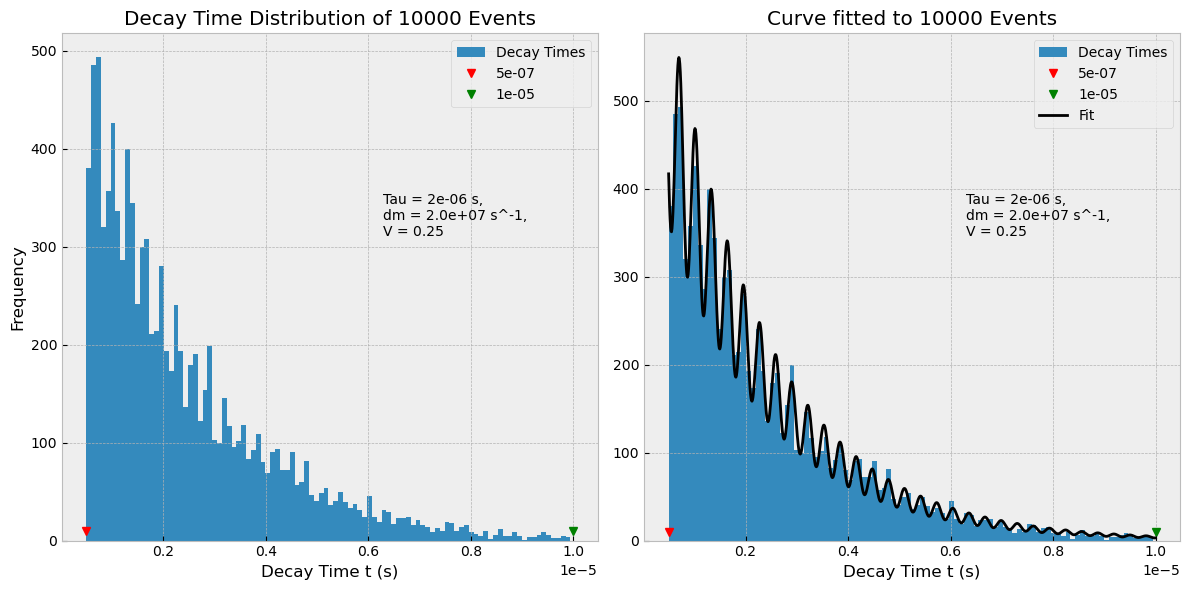

Integral of normalised pdf over bounds: 0.9999822402104821


In [23]:

# use iminuit to fit 
NLL = UnbinnedNLL(data, norm_pdf) # the NLL
m = Minuit(NLL, tau=tau_nom, dm=dm_nom, V=V_nom) # initial values as nominal values


# minimise
m.migrad() # find min of NLL
m.hesse() # find errors


# create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


# SUBPLOT 1 - data
ax[0].hist(data, bins=100, label="Decay Times") # plot the histogram
ax[0].plot(bounds[0], 10, marker="v", color="r", linestyle="None", label="{0}".format(bounds[0])) # lower band label
ax[0].plot(bounds[1], 10, marker="v", color="g", linestyle="None", label="{0}".format(bounds[1])) # upper band label
ax[0].set_title("Decay Time Distribution of 10000 Events")
ax[0].set_xlabel("Decay Time t (s)")
ax[0].set_ylabel("Frequency")
ax[0].text(0.6, 0.6, "Tau = {0} s, \ndm = {1:.1e} s^-1, \nV = {2}".format(tau_nom, dm_nom, V_nom), transform=ax[0].transAxes)
ax[0].legend()


# SUBPLOT 2 - data and fitted curve
x_plot = np.linspace(bounds[0], bounds[1], 1000) # generate x-values for plotting the function
y_plot = norm_pdf(x_plot, m.values["tau"], m.values["dm"], m.values["V"]) # calculate y-values using the fitted function
n, bins, patches = ax[1].hist(data, bins=100, label="Decay Times") # plot the histogram
bin_width = bins[1] - bins[0]
ax[1].plot(bounds[0], 10, marker="v", color="r", linestyle="None", label="{0}".format(bounds[0])) # lower band label
ax[1].plot(bounds[1], 10, marker="v", color="g", linestyle="None", label="{0}".format(bounds[1])) # upper band label
ax[1].plot(x_plot, y_plot * len(data) * bin_width, label="Fit", color="black") # plot the fitted function
ax[1].set_title("Curve fitted to 10000 Events")
ax[1].set_xlabel("Decay Time t (s)")
ax[1].text(0.6, 0.6, "Tau = {0} s, \ndm = {1:.1e} s^-1, \nV = {2}".format(tau_nom, dm_nom, V_nom), transform=ax[1].transAxes)
ax[1].legend()


plt.tight_layout()
plt.show()


# check normalisation of pdf
print("Integral of normalised pdf over bounds: {0}".format(integrate.quad(norm_pdf, bounds[0], bounds[1], args=(tau_nom, dm_nom, V_nom))[0]))


- Do this for multiple pseudoexperiments and calculate the mean and standard deviation of the distribution of fitted parameters

In [ ]:

# for loop over number of pseudoexperiments
pseudo = 1000
tau_values, dm_values, V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo)  # lists to contain obtained parameter values from each pseudoexperiment


for i in range(pseudo):

    # generate events
    data = generate()


    # fit the data
    NLL = UnbinnedNLL(data, norm_pdf) 
    m = Minuit(NLL, tau=tau_nom, dm=dm_nom, V=V_nom)


    # minimise
    m.migrad()
    m.hesse()


    # collect fitted parameter values
    tau_values[i] = m.values["tau"]
    dm_values[i] = m.values["dm"]
    V_values[i] = m.values["V"]



- Plot parameter value distributions over the pseudoexperiments
- precision: standard deviation of parameter distributions
- bias: parameter means - nominal parameter values

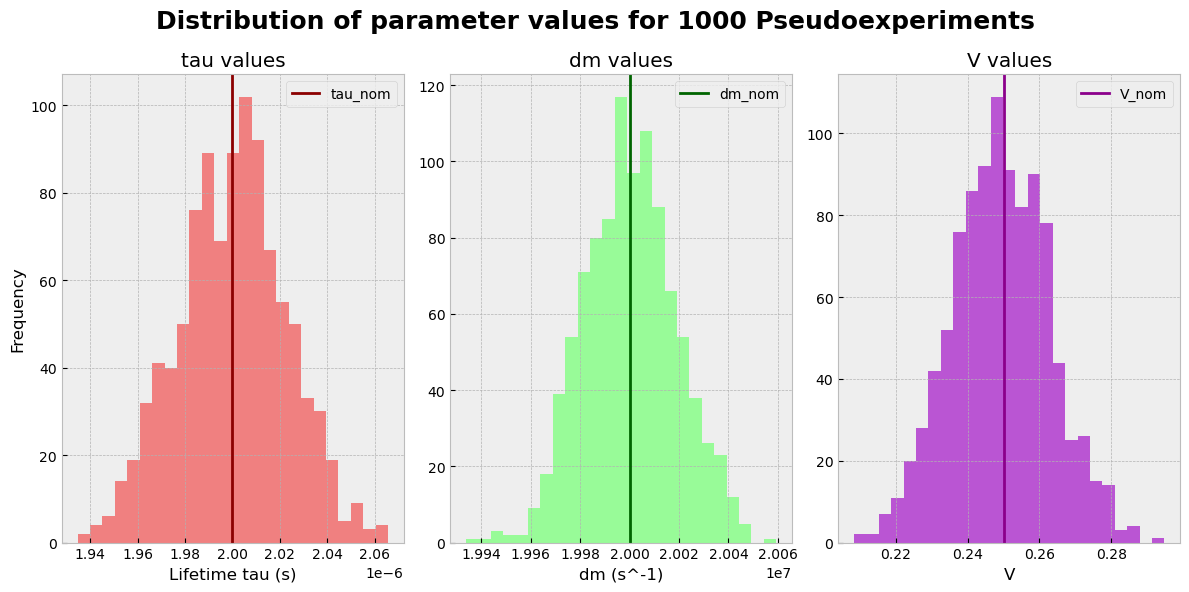

Pseudoexperiments: 1000

Fitted tau: 
Value = 2.0001311955649823e-06 
Precision(std) = 2.278059934379688e-08 
Bias = 1.3119556498239317e-10

Fitted dm: 
Value = 20000311.58419278 
Precision(std) = 18630.792615796036 
Bias = 311.58419277891517

Fitted V: 
Value = 0.2492085131861595 
Precision(std) = 0.013574550623572363 
Bias = -0.0007914868138405029


In [31]:

# calculate parameter mean, precision and bias
tau_mean, dm_mean, V_mean = np.average(tau_values), np.average(dm_values), np.average(V_values) # mean
tau_std, dm_std, V_std = np.std(tau_values), np.std(dm_values), np.std(V_values) # standard deviation (i.e precision)
tau_bias, dm_bias, V_bias =  (tau_mean - tau_nom), (dm_mean - dm_nom), (V_mean - V_nom) # bias


# create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle("Distribution of parameter values for {} Pseudoexperiments".format(pseudo), fontsize=18, fontweight="bold")


# SUBPLOT 1 - tau
ax[0].hist(tau_values, bins=25, color="lightcoral") # plot the histogram
ax[0].axvline(tau_nom, linestyle="-", color="darkred", label="tau_nom") # nominal tau value for reference
ax[0].set_title("tau values")
ax[0].set_xlabel("Lifetime tau (s)")
ax[0].set_ylabel("Frequency")
ax[0].legend()


# SUBPLOT 2 - dm
ax[1].hist(dm_values, bins=25, color="palegreen")
ax[1].axvline(dm_nom, linestyle="-", color="darkgreen", label="dm_nom") # nominal dm value for reference
ax[1].set_title("dm values")
ax[1].set_xlabel("dm (s^-1)")
ax[1].legend()


# SUBPLOT 2 - V
ax[2].hist(V_values, bins=25, color="mediumorchid")
ax[2].axvline(V_nom, linestyle="-", color="darkmagenta", label="V_nom") # nominal V value for reference
ax[2].set_title("V values")
ax[2].set_xlabel("V")
ax[2].legend()


plt.tight_layout()
plt.show()


print("Pseudoexperiments: {0}".format(pseudo))
print(f"\nFitted tau: \nValue = {tau_mean} \nPrecision(std) = {tau_std} \nBias = {tau_bias}")
print(f"\nFitted dm: \nValue = {dm_mean} \nPrecision(std) = {dm_std} \nBias = {dm_bias}")
print(f"\nFitted V: \nValue = {V_mean} \nPrecision(std) = {V_std} \nBias = {V_bias}")


## Step 2: Effect of a background

- the pdf for the background is: $$p(t;\sigma) \propto e^{-\frac{t^2}{2\sigma^2}}$$
$$\sigma = 0.5\times 10^{-6}\ \text{s}$$
- combine data pdf and background pdf with a mixer function for proportions: 1%, 10% and 20% background
- $\sigma$ not left as a free parameter

In [7]:

# given sigma value
sigma_nom = 0.5e-6


# define background pdf (not normalised)
def background_pdf(t):
    return np.exp((-t**2)/2*(sigma_nom**2))


# define normalised background pdf
def norm_background_pdf(t):

    t_samples = np.linspace(bounds[0], bounds[1], 1000)
    y_pdf = background_pdf(t_samples)
    N_background = integrate.trapezoid(y_pdf, t_samples) # trapezoidal numerical integration

    return background_pdf(t) / N_background


# define mixer function
def mix(t, f, tau, dm, V):
    return f*norm_background_pdf(t) + (1-f)*norm_pdf(t, tau, dm, V)

  
# define cdf
def cdf(i, f, tau, dm, V):

    t_samples = np.linspace(bounds[0], i, 1000)
    y_pdf = mix(t_samples, f, tau, dm, V)

    return integrate.trapezoid(y_pdf, t_samples)# integrate from lower bound to given i


# define event generation function
def bkgr_generate(f): # specify background proportion

    x = np.linspace(bounds[0], bounds[1], 1000) # interpolation points
    cdf_values = cdf(x, f, tau_nom, dm_nom, V_nom) # cdf values
    r = np.random.rand(10000) # random r's in range [0,1]
    events = np.interp(r, cdf_values, x, left=0, right=1) # inverse transform sampling
    
    return events

   
bgnd1 = bkgr_generate(0.01) # 1% background
bgnd2 = bkgr_generate(0.1) # 10% background
bgnd3 = bkgr_generate(0.2) # 20% background


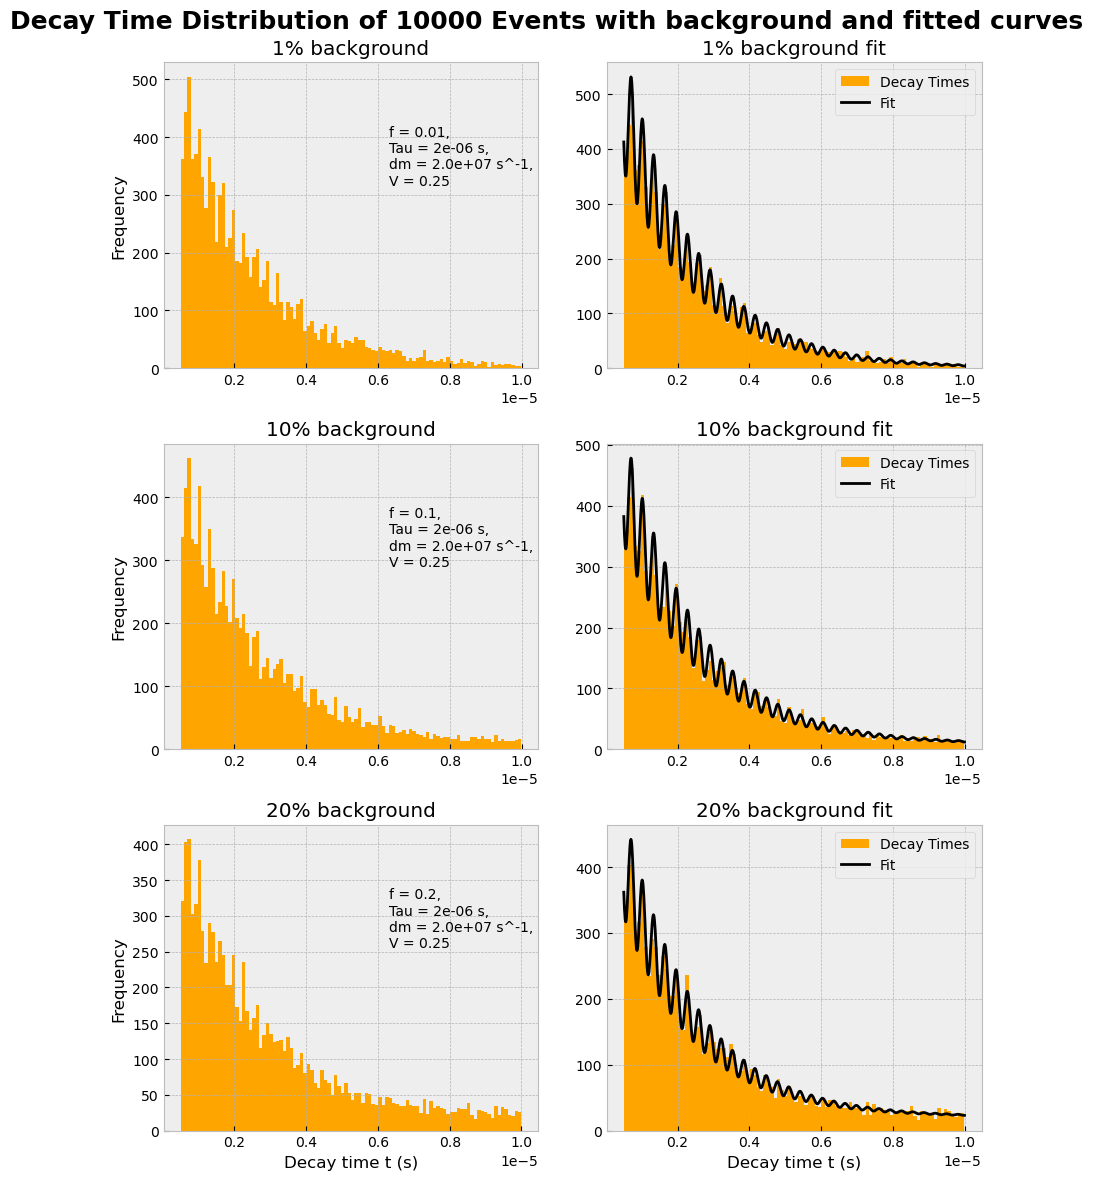

In [8]:

# fit bgnd1 - 1% background
m1 = Minuit(UnbinnedNLL(bgnd1, mix), f=0.01, tau=tau_nom, dm=dm_nom, V=V_nom) # initial values as nominal values
m1.migrad() # find min of NLL
m1.hesse() # find errors


# fit bgnd1 - 10% background
m2 = Minuit(UnbinnedNLL(bgnd2, mix), f=0.1, tau=tau_nom, dm=dm_nom, V=V_nom)
m2.migrad()
m2.hesse()


# fit bgnd1 - 20% background
m3 = Minuit(UnbinnedNLL(bgnd3, mix), f=0.2, tau=tau_nom, dm=dm_nom, V=V_nom)
m3.migrad()
m3.hesse()


# plotting
fig, ax = plt.subplots(3, 2, figsize=(9, 12))
fig.suptitle("Decay Time Distribution of 10000 Events with background and fitted curves", fontsize=18, fontweight="bold")


bgnd = [bgnd1, bgnd2, bgnd3]
m = [m1, m2, m3]
f = [0.01, 0.1, 0.2]


for i in range(3):

    # plot histograms for 1%, 10% and 20% background
    ax[i, 0].hist(bgnd[i], bins=100, color="orange")
    ax[i, 0].set_title(f"{int(f[i]*100)}% background")
    ax[i, 0].set_xlabel("Decay time t (s)" if i == 2 else None) # only plot x label for the bottom subplot
    ax[i, 0].set_ylabel("Frequency") # only plot y label for the leftmost subplots
    ax[i, 0].text(0.6, 0.6, f"f = {f[i]}, \nTau = {tau_nom} s, \ndm = {dm_nom:.1e} s^-1, \nV = {V_nom}", transform=ax[i, 0].transAxes)


    # plot fitted curve for 1%, 10% and 20% background
    x_plot = np.linspace(bounds[0], bounds[1], 1000)
    y_plot = mix(x_plot, m[i].values["f"], m[i].values["tau"], m[i].values["dm"], m[i].values["V"])
    n, bins, patches = ax[i, 1].hist(bgnd[i], bins=100, color="orange", label="Decay Times")
    bin_width = bins[1] - bins[0]
    ax[i, 1].plot(x_plot, y_plot * len(bgnd[i]) * bin_width, label="Fit", color="black")
    ax[i, 1].set_title(f"{int(f[i]*100)}% background fit")
    ax[i, 1].set_xlabel("Decay time t (s)" if i == 2 else None) # only plot x label for the bottom subplot
    ax[i, 1].legend()


plt.tight_layout()
plt.show()


- generate events with the background and the signal
- fit the generated data with a signal pdf and a combined pdf
- compare parameters obtained with the signal and combined pdfs
- signal fit: s
- combined fit: c

In [9]:

# for loop over number of pseudoexperiments for 1%, 10% and 20% background
signal1_tau_values, signal1_dm_values, signal1_V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo)  # signal pdf fit values for 1% background
signal2_tau_values, signal2_dm_values, signal2_V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo)  # signal pdf fit values for 10% background
signal3_tau_values, signal3_dm_values, signal3_V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo) # signal pdf fit values for 20% background

combined1_f_values, combined1_tau_values, combined1_dm_values, combined1_V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo)  # combined pdf fit values for 1% background
combined2_f_values, combined2_tau_values, combined2_dm_values, combined2_V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo)  # combined pdf fit values for 10% background
combined3_f_values, combined3_tau_values, combined3_dm_values, combined3_V_values = np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo), np.zeros(pseudo)  # combined pdf fit values for 20% background


for i in range(pseudo):

    # generate events for 1%, 10% and 20% background - THIS IS THE DATA THAT IS FIT TO
    bgnd1 = bkgr_generate(0.01)
    bgnd2 = bkgr_generate(0.1)
    bgnd3 = bkgr_generate(0.2)


    # fit bgnd1 with the signal and combined pdfs- 1% background
    s1 = Minuit(UnbinnedNLL(bgnd1, norm_pdf), tau=tau_nom, dm=dm_nom, V=V_nom) # signal fit on bgnd1 data
    s1.migrad()
    s1.hesse()


    c1 = Minuit(UnbinnedNLL(bgnd1, mix), f=0.01, tau=tau_nom, dm=dm_nom, V=V_nom) # combined fit on bgnd1 data
    c1.migrad()
    c1.hesse()


    signal1_tau_values[i], signal1_dm_values[i], signal1_V_values[i] = s1.values["tau"], s1.values["dm"], s1.values["V"] # collect parameters from fit
    combined1_f_values[i],  combined1_tau_values[i], combined1_dm_values[i], combined1_V_values[i] = c1.values["f"], c1.values["tau"], c1.values["dm"], c1.values["V"]
  

    # fit bgnd2 with the signal and combined pdfs- 10% background
    s2 = Minuit(UnbinnedNLL(bgnd2, norm_pdf), tau=tau_nom, dm=dm_nom, V=V_nom) # signal fit on bgnd2 data
    s2.migrad()
    s2.hesse()


    c2 = Minuit(UnbinnedNLL(bgnd2, mix), f=0.1, tau=tau_nom, dm=dm_nom, V=V_nom) # combined fit on bgnd2 data
    c2.migrad()
    c2.hesse()


    signal2_tau_values[i], signal2_dm_values[i], signal2_V_values[i] = s2.values["tau"], s2.values["dm"], s2.values["V"] # collect parameters from fit
    combined2_f_values[i],  combined2_tau_values[i], combined2_dm_values[i], combined2_V_values[i] = c2.values["f"], c2.values["tau"], c2.values["dm"], c2.values["V"]


    # fit bgnd3 with the signal and combined pdfs- 20% background
    s3 = Minuit(UnbinnedNLL(bgnd3, norm_pdf), tau=tau_nom, dm=dm_nom, V=V_nom) # signal fit on bgnd3 data
    s3.migrad()
    s3.hesse()


    c3 = Minuit(UnbinnedNLL(bgnd3, mix), f=0.1, tau=tau_nom, dm=dm_nom, V=V_nom) # combined fit on bgnd3 data
    c3.migrad()
    c3.hesse()


    signal3_tau_values[i], signal3_dm_values[i], signal3_V_values[i] = s3.values["tau"], s3.values["dm"], s3.values["V"] # collect parameters from fit
    combined3_f_values[i],  combined3_tau_values[i], combined3_dm_values[i], combined3_V_values[i] = c3.values["f"], c3.values["tau"], c3.values["dm"], c3.values["V"]


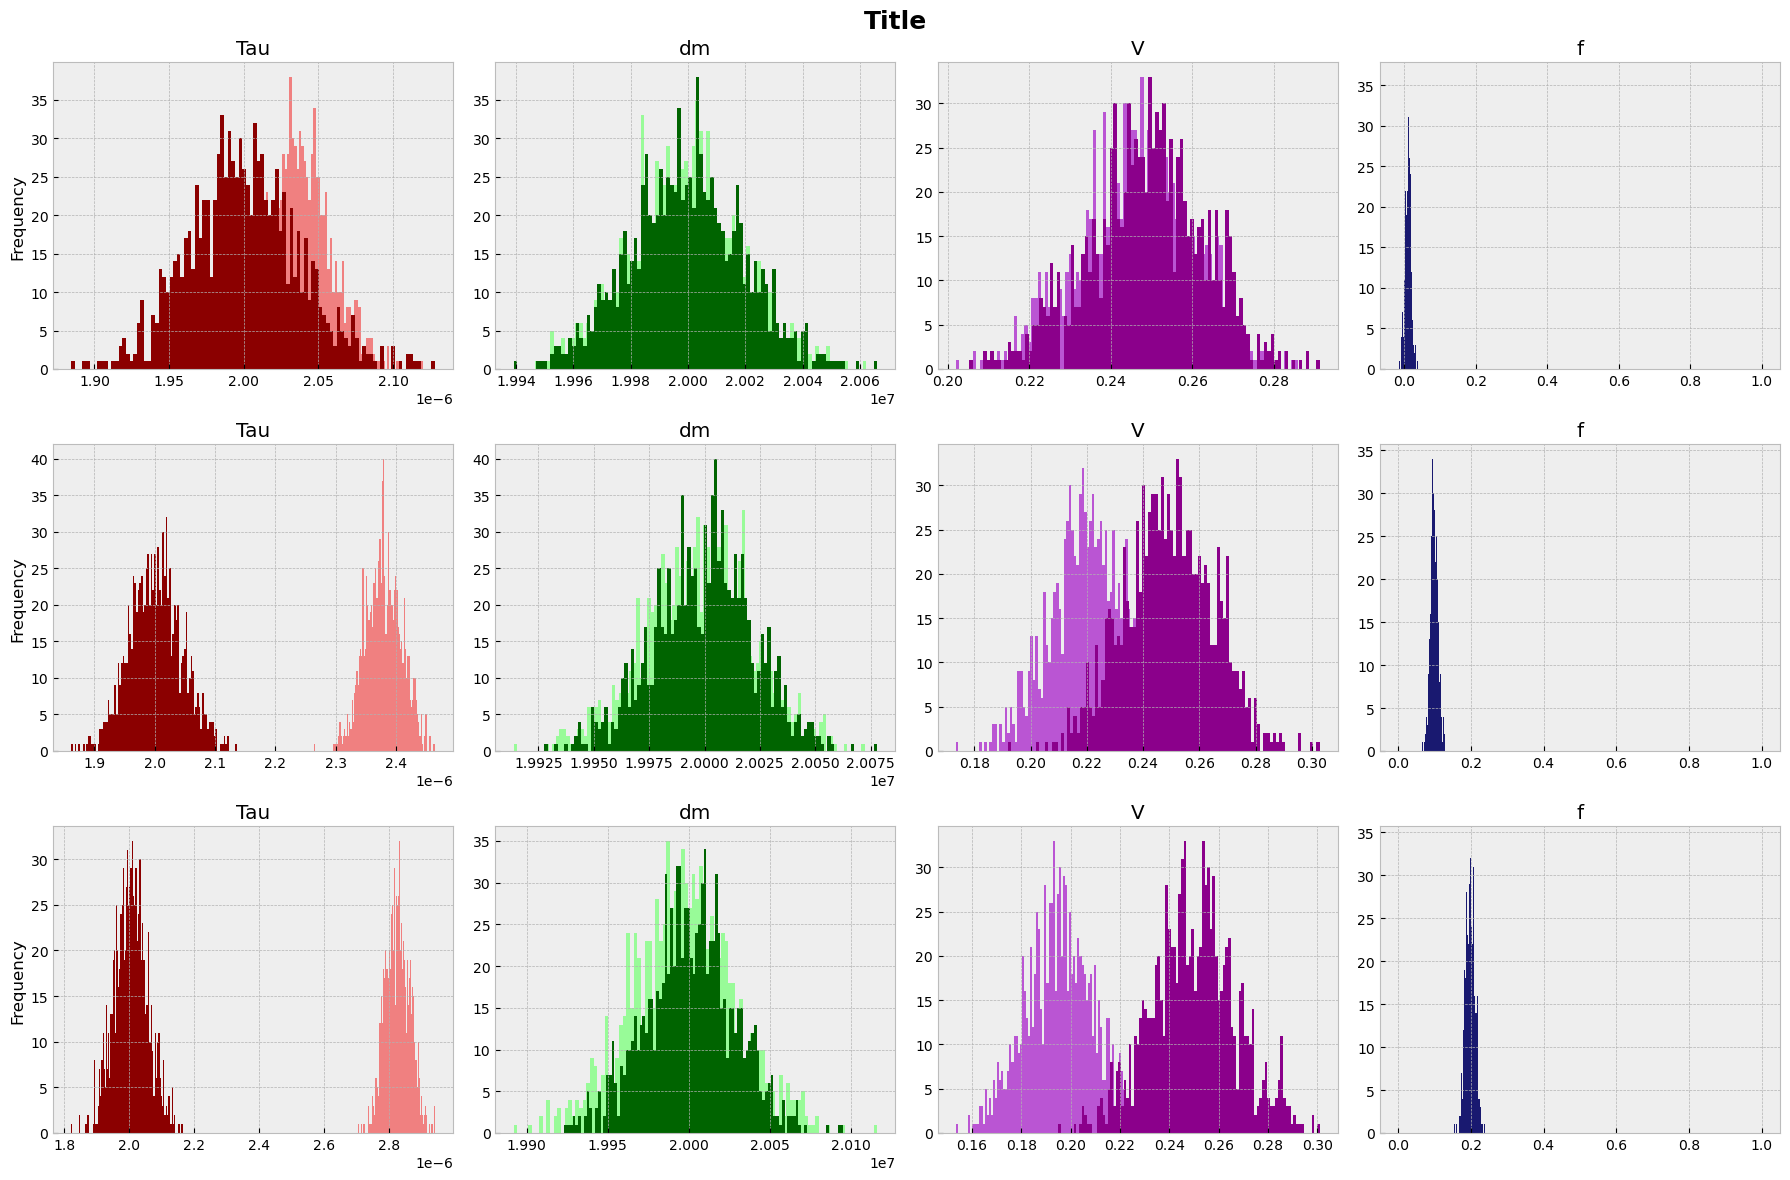

In [14]:

# plotting
fig, ax = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle("Title", fontsize=18, fontweight="bold")


types = ["Tau", "dm", "V", "f"]

signal1 = [signal1_tau_values, signal1_dm_values, signal1_V_values, []]
signal2 = [signal2_tau_values, signal2_dm_values, signal2_V_values, []]
signal3 = [signal3_tau_values, signal3_dm_values, signal3_V_values, []]
signal = [signal1, signal2, signal3]

combined1 = [combined1_tau_values, combined1_dm_values, combined1_V_values, combined1_f_values]
combined2 = [combined2_tau_values, combined2_dm_values, combined2_V_values, combined2_f_values]
combined3 = [combined3_tau_values, combined3_dm_values, combined3_V_values, combined3_f_values]
combined = [combined1, combined2, combined3]

signalcolors = ["lightcoral", "palegreen", "mediumorchid", "black"]
combinedcolors = ["darkred", "darkgreen", "darkmagenta", "midnightblue"]
f = [0.01, 0.1, 0.2]


for i in range(3): # rows - 1%, 10%, 20%
    for j in range(4): # columns - tau, dm, V, f

        # plot signal and combined parameter values
        ax[i, j].hist(signal[i][j], bins=100, color=signalcolors[j]) # DON'T PLOT THE F VALUES AS THEY DON'T EXIST
        ax[i, j].hist(combined[i][j], bins=100, color=combinedcolors[j])
        ax[i, j].set_title(f"{types[j]}")
        ax[i, j].set_ylabel("Frequency" if j == 0 else None) # only plot y label for the leftmost subplots
        #ax[i, j].text(0.6, 0.6, f"f = {f[i]}, \nTau = {tau_nom} s, \ndm = {dm_nom:.1e} s^-1, \nV = {V_nom}", transform=ax[i, 0].transAxes)


plt.tight_layout()
plt.show()


- calculate parameters' mean and standard deviation for each background case